# PyTorch 深度学习 - DNN
目标：熟悉 PyTorch 代码，能够看懂网上论文的代码，便于复现。
## 张量
数组与张量的联系和区别在 NumPy 库的知识中已经讲过，这里不再赘述。

In [49]:
# 防止 Jupyter 内核挂掉
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [74]:
# 查看设备的GPU方法
! nvidia-smi

Sun Mar 31 17:50:06 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 451.67       Driver Version: 451.67       CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce MX350      WDDM  | 00000000:2D:00.0 Off |                  N/A |
| N/A   58C    P0    N/A /  N/A |    591MiB /  2048MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                                  |
|  GPU  

In [51]:
import torch
# 默认的张量存储在CPU上
ts1 = torch.randn(3, 4)
print(ts1)
# 移动到GPU上
ts2 = ts1.to('cuda:0')
print(ts2)

tensor([[ 0.4894, -0.3460, -0.7810,  0.8359],
        [ 0.4554, -0.7711,  0.0126,  2.4097],
        [-1.8188, -0.0527, -0.9756, -0.1586]])
tensor([[ 0.4894, -0.3460, -0.7810,  0.8359],
        [ 0.4554, -0.7711,  0.0126,  2.4097],
        [-1.8188, -0.0527, -0.9756, -0.1586]], device='cuda:0')


以上操作可以把数据集放到 GPU 上，但是我们的神经网络模型也要放到 GPU 上才能正常运行。

## DNN 的原理
神经网络通过学习大量样本的输入与输出特征之间的关系，以拟合出输入和输出之间的方程，学习完成后，只给他输入特征，他便可以给出输出特征。神经网络可以分为这么几步：划分数据集，训练网络，测试网络，使用网络。

理论部分这里不再总结，可以自行去看专门的深度学习书籍，如李沐老师的[《动手学深度学习》](https://zh.d2l.ai/index.html)。

## DNN 的实现
torch.nn 提供了搭建神经网络的所有组件，nn 即 Neural Network 神经网络。因此可以单独给 torch.nn 一个别名，即 import torch.nn as nn。

In [52]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
%matplotlib inline
# 展示高清图
from matplotlib_inline import backend_inline
backend_inline.set_matplotlib_formats('svg')

### 制作数据集
在训练之前，我们要准备好训练集的样本。

In [53]:
# 生成数据集
X1 = torch.rand(10000, 1)
X2 = torch.rand(10000, 1)
X3 = torch.rand(10000, 1)

Y1 = ((X1 + X2 + X3) < 1).float()
Y2 = ((1 < (X1 + X2 + X3)) & ((X1 + X2 + X3) < 2)).float()
Y3 = ((X1 + X2 + X3) > 2).float()
Data = torch.cat([X1, X2, X3, Y1, Y2, Y3], axis=1)
Data = Data.to('cuda:0')
Data

tensor([[0.5464, 0.9095, 0.2710, 0.0000, 1.0000, 0.0000],
        [0.1628, 0.1165, 0.4844, 1.0000, 0.0000, 0.0000],
        [0.5651, 0.6449, 0.5013, 0.0000, 1.0000, 0.0000],
        ...,
        [0.3717, 0.5572, 0.4289, 0.0000, 1.0000, 0.0000],
        [0.6683, 0.1893, 0.1782, 0.0000, 1.0000, 0.0000],
        [0.9549, 0.7572, 0.3323, 0.0000, 0.0000, 1.0000]], device='cuda:0')

In [54]:
# 划分训练集与测试集
train_size = int(len(Data) * 0.7)
test_size = len(Data) - train_size
Data = Data[torch.randperm(Data.size(0)), :] # 打乱样本的顺序
train_Data = Data[:train_size, :] # 训练集样本
test_Data = Data[train_size:, :] # 测试集样本
train_Data.shape, test_Data.shape

(torch.Size([7000, 6]), torch.Size([3000, 6]))

### 搭建神经网络
搭建神经网络时，以 nn.Module 作为父类，我们自己的神经网络可直接继承父类的方法与属性，nn.Module 中包含网络各个层的定义。

在定义神经网络子类中，通常包含__init__特殊方法和 forward 方法。__init__特殊方法用于构造自己的神经网络结构，forward 方法用于将输入数据进行前向传播。由于张量可以自动计算梯度，所以不需要出现反向传播算法。

In [55]:
class DNN(nn.Module):
    def __init__(self):
        '''搭建神经网络各层'''
        super(DNN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(3, 5), nn.ReLU(),
            nn.Linear(5, 5), nn.ReLU(),
            nn.Linear(5, 5), nn.ReLU(),
            nn.Linear(5, 3)
        )

    def forward(self, x):
        '''前向传播'''
        y = self.net(x)
        return y
    
model = DNN().to('cuda:0')
model

DNN(
  (net): Sequential(
    (0): Linear(in_features=3, out_features=5, bias=True)
    (1): ReLU()
    (2): Linear(in_features=5, out_features=5, bias=True)
    (3): ReLU()
    (4): Linear(in_features=5, out_features=5, bias=True)
    (5): ReLU()
    (6): Linear(in_features=5, out_features=3, bias=True)
  )
)

### 神经网络的内部参数
神经网络的内部参数是权重与偏置，内部参数在神经网络训练之前会被赋予随机数，随着训练的进行，内部参数会逐渐迭代至最佳值，先对参数进行查看。

In [56]:
# 查看内部参数
for name, param in model.named_parameters():
    print(f"参数：{name}\n形状：{param.shape}\n数值：{param}\n")

参数：net.0.weight
形状：torch.Size([5, 3])
数值：Parameter containing:
tensor([[-0.4007, -0.0402, -0.5094],
        [ 0.4202, -0.1473, -0.0361],
        [ 0.5590,  0.5329, -0.3850],
        [ 0.3256, -0.4749,  0.4286],
        [-0.1441, -0.2915, -0.3366]], device='cuda:0', requires_grad=True)

参数：net.0.bias
形状：torch.Size([5])
数值：Parameter containing:
tensor([ 0.0613,  0.5387,  0.2464, -0.5410, -0.0447], device='cuda:0',
       requires_grad=True)

参数：net.2.weight
形状：torch.Size([5, 5])
数值：Parameter containing:
tensor([[ 0.3085,  0.1904, -0.3741, -0.1401,  0.4264],
        [-0.2222,  0.0373,  0.2605,  0.3708, -0.0822],
        [ 0.2288, -0.3417, -0.1019,  0.4040, -0.2795],
        [ 0.1238,  0.2912,  0.3403,  0.1401,  0.1319],
        [-0.3678,  0.1328,  0.3477,  0.3373, -0.0523]], device='cuda:0',
       requires_grad=True)

参数：net.2.bias
形状：torch.Size([5])
数值：Parameter containing:
tensor([-0.1587, -0.2625, -0.1526, -0.0206,  0.3655], device='cuda:0',
       requires_grad=True)

参数：net.4.weight

根据以上对神经网络的内部参数总结几点：
- 首先，net.0.weight 的权重形状为 (5, 3)，5 表示它自己的节点数是 5，3 表示与之连接的前一层的节点数是 3；

- 其次，由于上面的代码块中进行了 model = DNN().to('cuda:0') 操作，因此所有的内部参数都自带 device = 'cuda:0'；

- 最后，注意到 requires_grad = True，说明所有需要进行反向传播的内部参数（即权重与偏置）都打开了张量自带的梯度计算功能。

### 网络的外部参数
外部参数即**超参数**，这是调参时关注的重点。下面列举一些常用参数，具体可见[PyTorch官方文档](https://pytorch.org/docs/stable/nn.html)。
- 搭建网络的超参数有：网络层数，各隐藏层节点数，各节点激活函数，内部参数的初始值等；

- 训练网络的超参数有：损失函数，学习率，优化算法，batch_size，epochs等。

### 训练网络

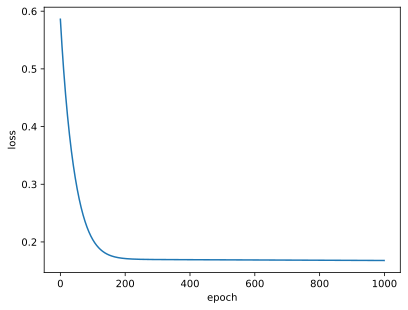

In [57]:
# 损失函数的选择
loss_fn = nn.MSELoss()

# 优化算法的选择
learning_rate = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# 训练网络
epochs = 1000
losses = []

# 给训练集划分输入和输出
X = train_Data[:, :3] # 前3列为输入特征
Y = train_Data[:, -3:] # 后3列为输出特征

for epoch in range(epochs):
    pred = model(X)             # 一次前向传播
    loss = loss_fn(pred, Y)     # 计算损失函数
    losses.append(loss.item())  # 记录损失函数的变化 
    optimizer.zero_grad()       # 清理上一轮滞留的梯度
    loss.backward()             # 一次反向传播
    optimizer.step()            # 优化内部参数

Fig = plt.figure()
plt.plot(range(epochs), losses)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

### 测试网络
测试时，只需要让测试集进行 1 次前向传播即可，这个过程不需要计算梯度，因此可以在该局部关闭梯度，该操作使用 with torch.no_grad(): 命令。

In [58]:
X = train_Data[:, :3] # 前3列为输入特征
Y = train_Data[:, -3:] # 后3列为输出特征

# 该局部关闭梯度计算功能
with torch.no_grad():
    pred = model(X)
    pred[:, torch.argmax(pred, axis=1)] = 1 # 将预测概率最大的设为1
    pred[pred != 1] = 0 # 其他预测值设为0
    correct = torch.sum((pred == Y).all(1)) # 统计预测正确的样本数量
    total = Y.size(0)
    print(f"测试集准确度：{100 * correct / total}%") 

测试集准确度：66.61428833007812%


### 保存与导入网络
现在我们要考虑一件大事，那就是有时候训练一个大网络需要几天，那么必须要把整个网络连同里面优化好的内部参数给保存下来。

现以前面的代码为例，当网络训练好后，将网络以文件的形式保存下来，并通过文件导入给另一个新网络，让新网络去跑测试集，看看准确率是否还是 67% 左右。

In [59]:
# 保存网络
torch.save(model, 'model1.pth')

# 把模型赋给新网络
new_model = torch.load('model1.pth')

# 用新网络测试
X = train_Data[:, :3] # 前3列为输入特征
Y = train_Data[:, -3:] # 后3列为输出特征

# 该局部关闭梯度计算功能
with torch.no_grad():
    pred = new_model(X)
    pred[:, torch.argmax(pred, axis=1)] = 1 # 将预测概率最大的设为1
    pred[pred != 1] = 0 # 其他预测值设为0
    correct = torch.sum((pred == Y).all(1)) # 统计预测正确的样本数量
    total = Y.size(0)
    print(f"测试集准确度：{100 * correct / total}%") 

测试集准确度：66.61428833007812%


批量梯度下降项目实战主要比前面多了一个准备数据集（Excel 导入）的过程：导入数据，Pandas 对象退化为 NumPy 数组，转为 float32 类型数组，再转为张量，把数据集搬到 cuda 上。

## 小批量梯度下降
本章将继续使用上面的神经网络结构，但使用小批量训练。需要使用 3 个 PyTorch 内置的实用工具（utils）：
- DataSet 用于封装数据集；
- DataLoader 用于加载数据不同的批次；
- random_split 用于划分训练集和测试集。

## 项目实战：手写数字识别
手写数字识别数据集（MNIST）是机器学习领域的标准数据集，它被称为机器学习领域的“Hello World!”，只因任何 AI 算法都可以用此标准数据集进行检验。MNIST 内的每一个样本都是一副二维的灰度图像。

在 MNIST 中，模型的输入是一副图像，模型的输出是一个与图像对应的数字（0-9 之间的一个整数）。

### 制作数据集
这一部分我们需要在 torchvision 库中分别下载训练集与测试集，因此需要从 torchvision 库中导入 datasets 以下载数据集，下载前需要借助 torchvision 库中的 transforms 进行图像转换，将数据集变为张量，并调整数据集的统计分布。

由于不需要手动构建数据集，因此不导入 utils 中的 Dataset；又由于训练集和测试集是分开下载的，因此不导入 utils 中的 random_split。

In [65]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision import datasets
import matplotlib.pyplot as plt
%matplotlib inline
# 展示高清图
from matplotlib_inline import backend_inline
backend_inline.set_matplotlib_formats('svg')

在下载数据集之前，要设定转换参数：transform，该参数解决两个问题：
- ToTensor：将图像数据转为张量，且调整三个维度的顺序为 C * W * H；C 表示通道数，二位灰度图像的通道数为 1，三维 RGB 彩色图片的通道数为 3；
- Normalize：将神经网络的输入数据转化为正态分布，训练效果更好；根据统计计算，MNIST 数据集所有像素的均值是 0.1307，标准差是 0.3081。

In [66]:
# 制作数据集

# 设定下载参数
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.1307, 0.3081)
])

# 下载训练集与测试集
train_data = datasets.MNIST(
    root='dataset/mnist/',
    train=True,
    download=True,
    transform=transform
)
test_data = datasets.MNIST(
    root='dataset/mnist/',
    train=False,
    download=True,
    transform=transform
)

100.0%


Extracting dataset/mnist/MNIST\raw\train-images-idx3-ubyte.gz to dataset/mnist/MNIST\raw



100.0%


Extracting dataset/mnist/MNIST\raw\train-labels-idx1-ubyte.gz to dataset/mnist/MNIST\raw



100.0%


Extracting dataset/mnist/MNIST\raw\t10k-images-idx3-ubyte.gz to dataset/mnist/MNIST\raw



100.0%

Extracting dataset/mnist/MNIST\raw\t10k-labels-idx1-ubyte.gz to dataset/mnist/MNIST\raw



In [71]:
# 批次加载器
train_loader = DataLoader(train_data, shuffle=True, batch_size=64)
test_loader = DataLoader(test_data, shuffle=False, batch_size=64)

### 搭建神经网络

In [72]:
class DNN(nn.Module):
    def __init__(self):
        '''搭建神经网络各层'''
        super(DNN, self).__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784, 512), nn.ReLU(),
            nn.Linear(512, 256), nn.ReLU(),
            nn.Linear(256, 128), nn.ReLU(),
            nn.Linear(128, 64), nn.ReLU(),
            nn.Linear(64, 10)
        )

    def forward(self, x):
        '''前向传播'''
        return self.net(x)

model = DNN().to('cuda:0')
model

DNN(
  (net): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=512, bias=True)
    (2): ReLU()
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): ReLU()
    (5): Linear(in_features=256, out_features=128, bias=True)
    (6): ReLU()
    (7): Linear(in_features=128, out_features=64, bias=True)
    (8): ReLU()
    (9): Linear(in_features=64, out_features=10, bias=True)
  )
)

### 训练网络

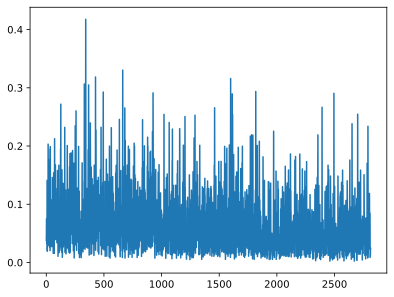

In [75]:
# 损失函数
loss_fn = nn.CrossEntropyLoss()

# 优化算法
learning_rate = 0.01
optimizer = torch.optim.SGD(
    model.parameters(),
    lr=learning_rate,
    momentum=0.5
)

# 训练网络
epochs = 3
losses = []

for epoch in range(epochs):
    for (x, y) in train_loader:
        x, y = x.to('cuda:0'), y.to('cuda:0')
        pred = model(x)             
        loss = loss_fn(pred, y)     
        losses.append(loss.item())  
        optimizer.zero_grad()       
        loss.backward()             
        optimizer.step()            

Fig = plt.figure()
plt.plot(range(len(losses)), losses)
plt.show()

### 测试网络

In [76]:
correct = 0
total = 0

with torch.no_grad():
    for (x, y) in test_loader:
        x, y = x.to('cuda:0'), y.to('cuda:0')
        pred = model(x)
        _, predicted = torch.max(pred.data, dim=1) # 得到最大预测概率的索引，如预测的是数字5，再看标签y是不是5
        correct += torch.sum(predicted == y)
        total += y.size(0)
        
print(f"测试集准确度：{100 * correct / total}%") 

测试集准确度：97.75999450683594%
